In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip '/content/drive/MyDrive/FYP-Data.zip'


In [ ]:
import tensorflow as tf

In [ ]:
IMG_SHAPE=(224,224,3)
base_model= tf.keras.applications.MobileNet(weights='imagenet',input_shape=IMG_SHAPE, include_top=False)
x=base_model.output
x= tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(6,activation='softmax')(x) #final layer with softmax activation

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

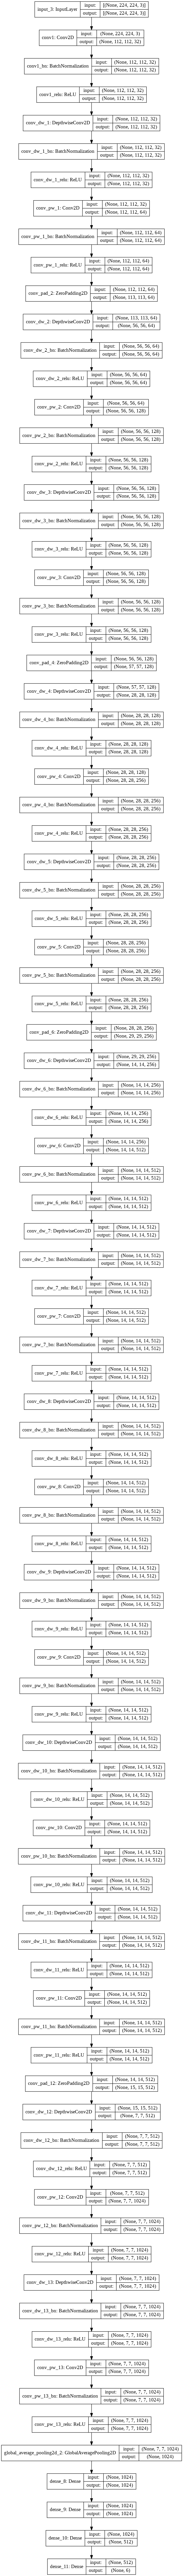

In [ ]:
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_3
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_10
62 conv_dw_10_bn
63 conv_dw_10_relu
64 conv_pw_10
65 conv_pw_1

In [ ]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('/content/drive/MyDrive/Data/Train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)
dev_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) #included in our dependencies

dev_generator=dev_datagen.flow_from_directory('/content/drive/MyDrive/Data/Dev',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) #included in our dependencies

test_generator=test_datagen.flow_from_directory('/content/drive/MyDrive/Data/Test',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 4358 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Found 1199 images belonging to 6 classes.


In [ ]:
import sklearn.metrics as metrics
from keras import backend as K
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def AUC(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP / (P + 1)

# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP / (N + 1)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m,binary_PTA, binary_PFA, AUC])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/TFLite2/mobileNet_1.pb",
                                                monitor="val_accuracy",
                                                verbose=0,
                                                save_best_only=True,
                                                )

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         min_delta=0,
                                         patience=20,
                                         verbose=1,
                                         mode='auto')

In [ ]:
history=model.fit(train_generator,
                         steps_per_epoch= 2,
                         epochs= 50,
                         validation_data= dev_generator,
                         validation_steps=1,
                         callbacks=[checkpoint,early],
                         verbose=1)

Epoch 1/50
2/2 [==============================] - 96s 43s/step - loss: 1.8136 - accuracy: 0.2031 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - binary_PTA: 0.0000e+00 - binary_PFA: 0.0000e+00 - AUC: 0.5536 - val_loss: 1.8613 - val_accuracy: 0.1875 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_binary_PTA: 0.0000e+00 - val_binary_PFA: 0.0000e+00 - val_AUC: 0.4988
INFO:tensorflow:Assets written to: /content/drive/My Drive/TFLite2/mobileNet_1.pb/assets
Epoch 2/50
2/2 [==============================] - 18s 10s/step - loss: 1.7322 - accuracy: 0.2969 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - binary_PTA: 0.0000e+00 - binary_PFA: 0.0000e+00 - AUC: 0.5996 - val_loss: 1.8486 - val_accuracy: 0.1250 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_binary_PTA: 0.0000e+00 - val_binary_PFA: 0.0000e+00 - val_AUC: 0.4907
Epoch 3/50
2/2 [==============================] - 16s 10s

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2/2 [==============================] - 19s 11s/step - loss: 1.0250 - accuracy: 0.7031 - f1_m: 0.4176 - precision_m: 1.0000 - recall_m: 0.2656 - binary_PTA: 0.2576 - binary_PFA: 0.0000e+00 - AUC: 0.9173 - val_loss: 1.0552 - val_accuracy: 0.7500 - val_f1_m: 0.3590 - val_precision_m: 1.0000 - val_recall_m: 0.2188 - val_binary_PTA: 0.2121 - val_binary_PFA: 0.0000e+00 - val_AUC: 0.9240
INFO:tensorflow:Assets written to: /content/drive/My Drive/TFLite2/mobileNet_1.pb/assets
Epoch 12/50
2/2 [==============================] - 17s 10s/step - loss: 0.9260 - accuracy: 0.8438 - f1_m: 0.4707 - precision_m: 0.9545 - recall_m: 0.3125 - binary_PTA: 0.3030 - binary_PFA: 0.0031 - AUC: 0.9291 - val_loss: 1.1752 - val_accuracy: 0.6562 - val_f1_m: 0.1667 - val_precision_m: 0.7500 - val_recall_m: 0.0938 - val_binary_PTA: 0.0909 - val_binary_PFA: 0.0062 - val_AUC: 0.8822
Epoch 13/50
2/2 [==============================] - 18s 11s/step - loss: 0.9042 - accuracy: 0.7812 - f1_m: 0.5172 - precision_m: 0.9231 - re

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2/2 [==============================] - 18s 10s/step - loss: 0.3221 - accuracy: 0.8906 - f1_m: 0.9108 - precision_m: 0.9531 - recall_m: 0.8750 - binary_PTA: 0.8485 - binary_PFA: 0.0093 - AUC: 0.9628 - val_loss: 0.3988 - val_accuracy: 0.8750 - val_f1_m: 0.8667 - val_precision_m: 0.9286 - val_recall_m: 0.8125 - val_binary_PTA: 0.7879 - val_binary_PFA: 0.0124 - val_AUC: 0.9625
Epoch 28/50
2/2 [==============================] - 19s 12s/step - loss: 0.3258 - accuracy: 0.9062 - f1_m: 0.9111 - precision_m: 0.9516 - recall_m: 0.8750 - binary_PTA: 0.8485 - binary_PFA: 0.0093 - AUC: 0.9634 - val_loss: 0.4174 - val_accuracy: 0.8750 - val_f1_m: 0.8421 - val_precision_m: 0.9600 - val_recall_m: 0.7500 - val_binary_PTA: 0.7273 - val_binary_PFA: 0.0062 - val_AUC: 0.9588
Epoch 29/50
2/2 [==============================] - 18s 10s/step - loss: 0.2529 - accuracy: 0.9375 - f1_m: 0.9180 - precision_m: 0.9655 - recall_m: 0.8750 - binary_PTA: 0.8485 - binary_PFA: 0.0062 - AUC: 0.9666 - val_loss: 0.4724 - val_a

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


2/2 [==============================] - 17s 11s/step - loss: 0.1885 - accuracy: 0.9375 - f1_m: 0.9370 - precision_m: 0.9531 - recall_m: 0.9219 - binary_PTA: 0.8939 - binary_PFA: 0.0093 - AUC: 0.9672 - val_loss: 0.3322 - val_accuracy: 0.8750 - val_f1_m: 0.8571 - val_precision_m: 0.8710 - val_recall_m: 0.8438 - val_binary_PTA: 0.8182 - val_binary_PFA: 0.0248 - val_AUC: 0.9610
Epoch 43/50
2/2 [==============================] - 18s 11s/step - loss: 0.2219 - accuracy: 0.9219 - f1_m: 0.9134 - precision_m: 0.9209 - recall_m: 0.9062 - binary_PTA: 0.8788 - binary_PFA: 0.0155 - AUC: 0.9657 - val_loss: 0.6709 - val_accuracy: 0.6562 - val_f1_m: 0.6774 - val_precision_m: 0.7000 - val_recall_m: 0.6562 - val_binary_PTA: 0.6364 - val_binary_PFA: 0.0559 - val_AUC: 0.9290
Epoch 44/50
2/2 [==============================] - 19s 12s/step - loss: 0.2034 - accuracy: 0.9688 - f1_m: 0.9759 - precision_m: 1.0000 - recall_m: 0.9531 - binary_PTA: 0.9242 - binary_PFA: 0.0000e+00 - AUC: 0.9693 - val_loss: 0.2997 - v

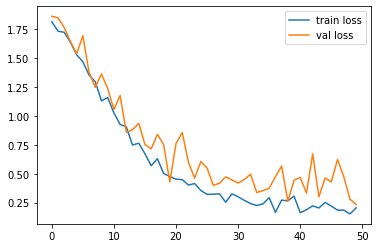

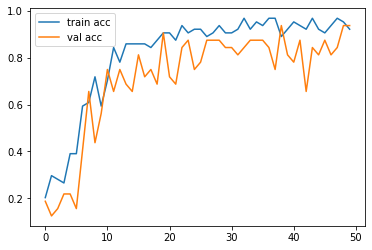

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

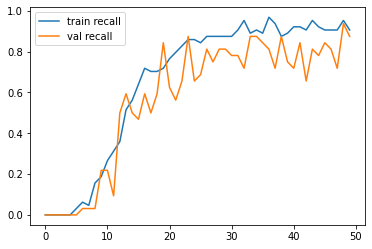

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the recall
import matplotlib.pyplot as plt
plt.plot(history.history['recall_m'], label='train recall')
plt.plot(history.history['val_recall_m'], label='val recall')
plt.legend()
plt.show()
plt.savefig('recall')

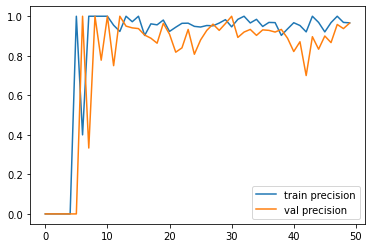

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the precision
plt.plot(history.history['precision_m'], label='train precision')
plt.plot(history.history['val_precision_m'], label='val precision')
plt.legend()
plt.show()
plt.savefig('precision')

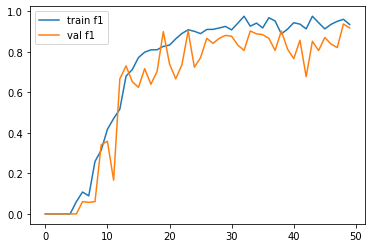

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the f1
plt.plot(history.history['f1_m'], label='train f1')
plt.plot(history.history['val_f1_m'], label='val f1')
plt.legend()
plt.show()
plt.savefig('F1score')

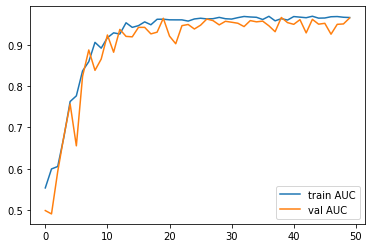

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the f1
plt.plot(history.history['AUC'], label='train AUC')
plt.plot(history.history['val_AUC'], label='val AUC')
plt.legend()
plt.show()
plt.savefig('AUC')

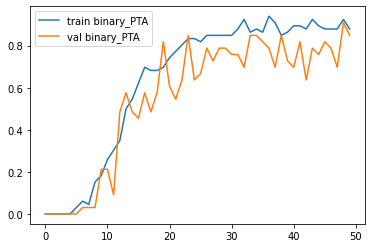

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the f1
plt.plot(history.history['binary_PTA'], label='train binary_PTA')
plt.plot(history.history['val_binary_PTA'], label='val binary_PTA')
plt.legend()
plt.show()
plt.savefig('PTA')

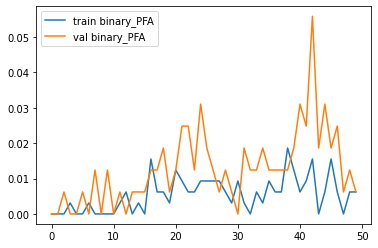

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the f1
plt.plot(history.history['binary_PFA'], label='train binary_PFA')
plt.plot(history.history['val_binary_PFA'], label='val binary_PFA')
plt.legend()
plt.show()
plt.savefig('PFA')

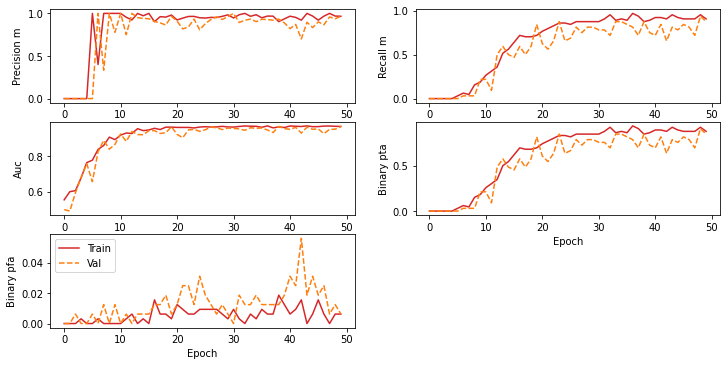

<Figure size 864x720 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics =  ['precision_m', 'recall_m','AUC','binary_PTA','binary_PFA']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(5, 2, n+1)  # adjust according to metrics
        plt.plot(history.epoch,  history.history[metric], color=colors[3], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        # selecting the metric, the value of plt.ylim could be changed
    plt.legend()
    plt.show()
    plt.savefig('OverallGraphs')
    

plot_metrics(history)

In [ ]:
# new_model = tf.keras.models.load_model('/content/drive/MyDrive/TFLite2/mobileNet_1.pb')

In [ ]:
score=model.evaluate(test_generator)
print(score)

 7/38 [====>.........................] - ETA: 3:18 - loss: 0.2122 - accuracy: 0.9286 - f1_m: 0.9117 - precision_m: 0.9371 - recall_m: 0.8884 - binary_PTA: 0.8615 - binary_PFA: 0.0115 - AUC: 0.9651

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


38/38 [==============================] - 332s 9s/step - loss: 0.2327 - accuracy: 0.9208 - f1_m: 0.9152 - precision_m: 0.9357 - recall_m: 0.8963 - binary_PTA: 0.8683 - binary_PFA: 0.0121 - AUC: 0.9634
[0.2327110916376114, 0.9207673072814941, 0.9151585102081299, 0.9357279539108276, 0.8962719440460205, 0.8683212399482727, 0.012114813551306725, 0.9634096026420593]


In [ ]:
y_preds = model.predict(test_generator)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
saved_model_dir = '/content/drive/My Drive/TFLite2'
tf.saved_model.save(model, saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open('/content/drive/My Drive/TFLite2/model_final.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /content/drive/My Drive/TFLite2/assets


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('/content/drive/My Drive/TFLite2/labels_final.txt', 'w') as f:
    f.write(labels)